## Importing libraries

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import LSTM, Flatten

from google.colab import drive
drive.mount('/content/drive')

# To get reproducible results
from numpy.random import seed 
seed(0) 
tensorflow.random.set_seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [46]:
df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Lab dataset/reactor1_biogas.csv', index_col="day", usecols=["day", "reactor1"])
# df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Lab dataset/reactor1_biogas.csv', usecols=[1])
df.sort_index(inplace=True)
df.head()

,reactor1
day,
0,0
1,100
2,120
3,100
4,100


## Plotting the biogas values
This section takes a look at the trend in the biogas values.

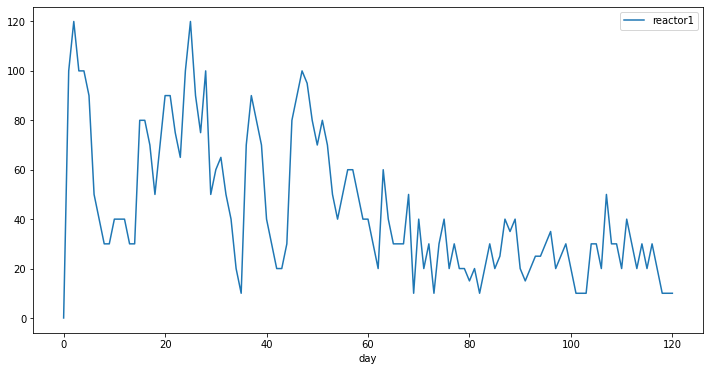

In [47]:
df.plot(figsize=(12,6))

### Decomposing the plot
Using seasonal-decompose to find a trend, seasonal changes and noise in the plot.

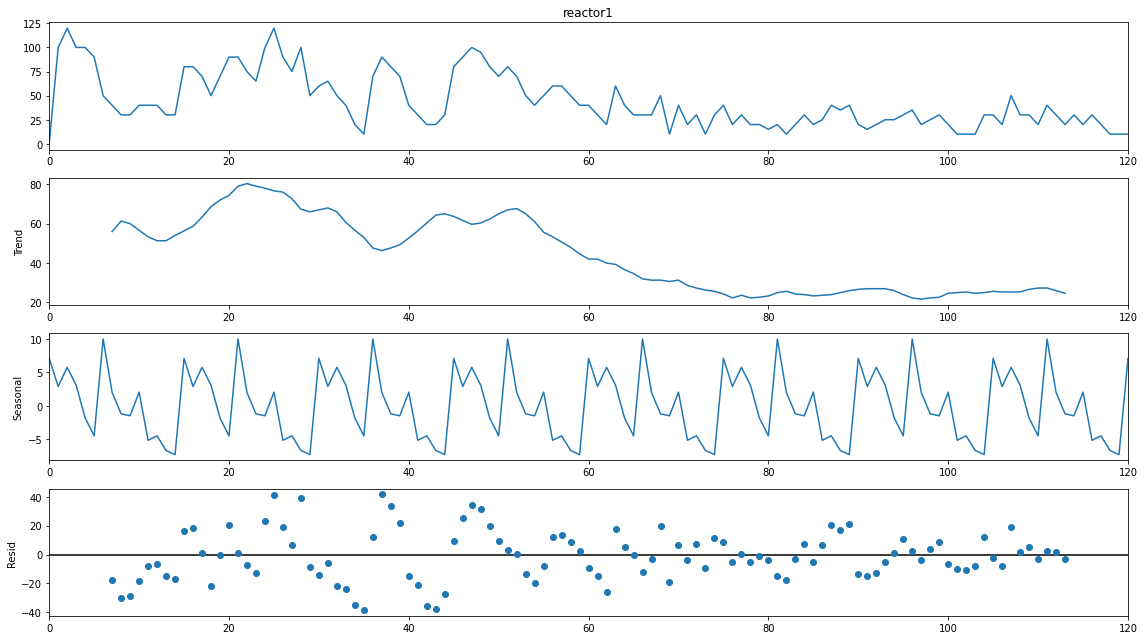

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(x=df['reactor1'], period = 15,  model='additive')
decompose_plot = results.plot();
decompose_plot.set_size_inches((16, 9))
# Tight layout to realign things
decompose_plot.tight_layout()
decompose_plot.show()

## Scaling the data
The train-test split needs to be done in a sequential manner, and not randomly.

In [49]:
# Using the MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(df)

scaled_dataset = scaler.transform(df)

## Generating sequences
To generate a series based input for our model.

In [50]:
def sequenceGenerator(dataset, sequenceSize=1):
  #Function that returns X and y from a given set of data points, where X is a set of sequences
    X = []
    y = []

    # using a sliding window to get values for the sequence. The value just after the sequnce is used as y
    for i in range(len(dataset)-sequenceSize-1):
        current_window = dataset[i:(i+sequenceSize), 0]
        X.append(current_window)
        y.append(dataset[i+sequenceSize, 0])
        
    return np.array(X),np.array(y)

# Using the function to generate train and test sequences

# Defining the sequence size to be used.
sequence_size = 15
X, y = sequenceGenerator(scaled_dataset, sequence_size)
len(X)

105

## Splitting into train and test set
This needs to be done sequentially.

In [51]:
# Setting a fraction for train data
train_fraction = 0.7
train_size = (int)(len(X)*train_fraction)

# Splitting the train and test data
X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size :]
y_test = y[train_size :]

# Building LSTM models

## Input shape
LSTMs expect input array to be a 3D array: (batch_size, time_steps, seq_len)
* `batch_size` = Number of inputs in the training data
* `time_steps` = Number of historical datapoints being given
* `seq_len` = Number of features in a single historical datapoint

Example 1: If there are 2500 training sentences, with 50 words in each, with each word being encoded as an integer, then the input shape would be: `(2500, 50, 1)` 

So, for univariate analysis, the input shape will be:  
`(num_training_observations, sequence_size, 1)`


In [52]:
# Reshaping the train and test data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## a) 1 LSTM layer (20 neurons) + 1 Dense layer (20 neurons)

In [61]:
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1], 1)))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20)                1760      
                                                                 
 dense_8 (Dense)             (None, 20)                420       
                                                                 
 dense_9 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,201
Trainable params: 2,201
Non-trainable params: 0
_________________________________________________________________


In [62]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 2s 280ms/step - loss: 0.7213 - val_loss: 0.2652
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6829 - val_loss: 0.2350
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6519 - val_loss: 0.2131
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 0.6406 - val_loss: 0.1928
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6244 - val_loss: 0.1770
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6164 - val_loss: 0.1625
Epoch 7/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6094 - val_loss: 0.1527
Epoch 8/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6025 - val_loss: 0.1456
Epoch 9/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5973 - val_loss: 0.1412
Epoch 10/100
3/3 [==============================] - 0s 20ms/step - loss: 0.5911 - val_loss: 0.1386
Epoch 11/100
3/3 [

### Plotting the loss

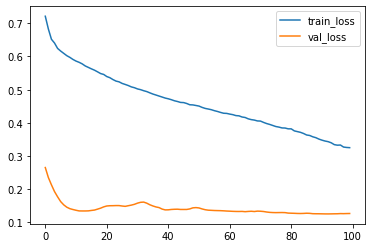

In [63]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 0s 4ms/step


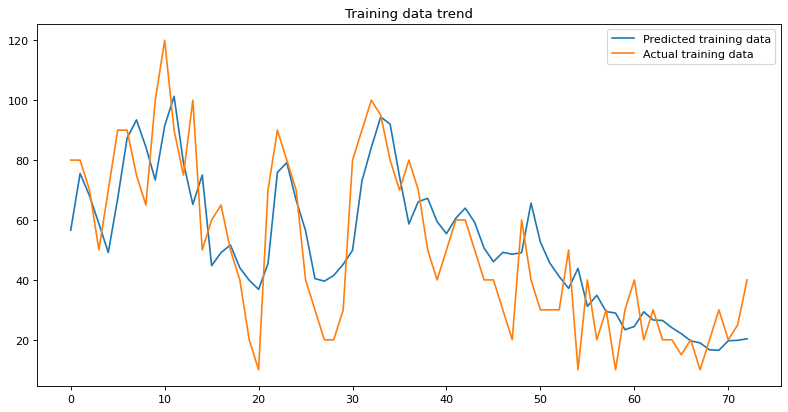

In [64]:
# TRAINING DATA

# Making predctions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

predicted_train_inv = scaler.inverse_transform(predicted_train)
actual_train_inv = scaler.inverse_transform(actual_train)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
plt.title("Training data trend")
plt.show()

1/1 [==============================] - 0s 17ms/step


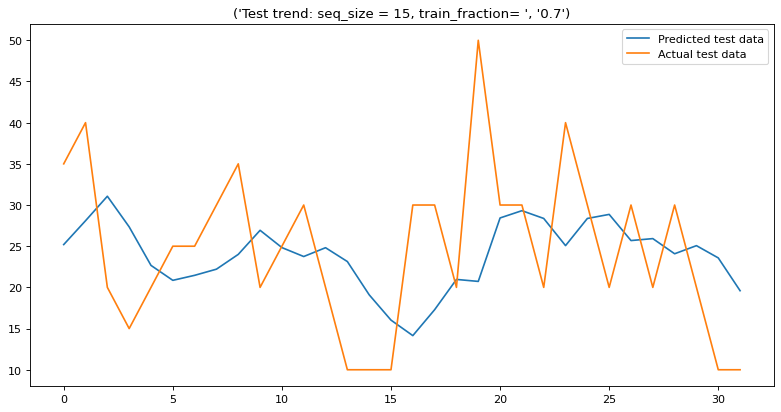

In [65]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

predicted_test_inv = scaler.inverse_transform(predicted_test)
actual_test_inv = scaler.inverse_transform(actual_test)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "Test trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

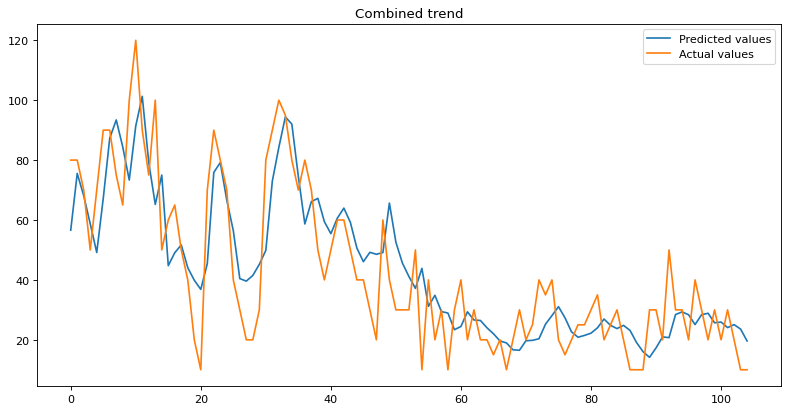

In [66]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)
actual_combined_inv = scaler.inverse_transform(actual_combined)
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
plt.title("Combined trend")
plt.show()

### Calculating the R2 score

In [67]:
from sklearn.metrics import r2_score

# Train, test, combined
print(round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

0.661 ,  -0.076 ,  0.701


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [68]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print(round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


16.027 ,  9.956 ,  14.449


### Analysis
**1. Sequence size of 5, train size of 0.7**
1. There is a lag both in the training as well as testing predictions
2. The trend in the testing data is being followed better than how it was in ANN, but overall the valeus being predicted are higher than actual values.
3. As the training size increases, test prediction values are getting worse. The trend is followed to a lesser degree; values are close to a value higher than the mean.
4. r2 score: 0.553, -0.624, 0.596
5. RMSE: 17.899, 12.185, 16.373

**2. Sequence size of 15, train size of 0.7**  
1. The lag has decreased (from its value when sequence size was 5), in training data.
2. On the test set, the trend is not being followed to a good degree. Values are close to the mean, which is why the r2 score is close to 0 (still negative).
3. r2 score: 0.672 ,  -0.011 ,  0.711
4. RMSE: 15.773 ,  9.649 ,  14.189

## b) Single LSTM layer (64 neurons)

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 64)                16896     
                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 3s 306ms/step - loss: 0.9192 - val_loss: 0.5191
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 0.8506 - val_loss: 0.4819
Epoch 3/100
3/3 [==============================] - 0s 21ms/step - loss: 0.7969 - val_loss: 0.4450
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 0.7602 - val_loss: 0.4091
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 0.7384 - val_loss: 0.3800
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 0.7188 - val_loss: 0.3578
Epoch 7/100
3/3 [==============================] - 0s 22ms/step - loss: 0.7110 - val_loss: 0.3380
Epoch 8/100
3/3 [==============================] - 0s 22ms/step - loss: 0.7021 - val_loss: 0.3226
Epoch 9/100
3/3 [==============================] - 0s 21ms/step - loss: 0.6939 - val_loss: 0.3124
Epoch 10/100
3/3 [==============================] - 0s 24ms/step - loss: 0.6835 - val_loss: 0.3061
Epoch 11/100
3/3 [

### Plotting the loss

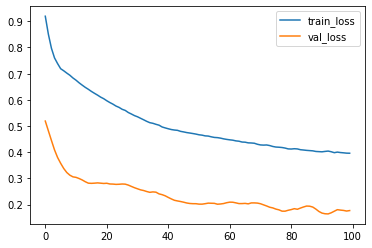

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 5ms/step


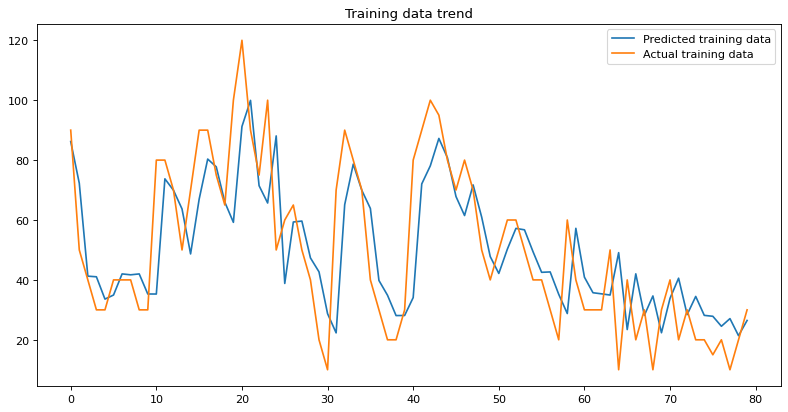

In [ ]:
# TRAINING DATA

# Making predctions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

predicted_train_inv = scaler.inverse_transform(predicted_train)
actual_train_inv = scaler.inverse_transform(actual_train)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
plt.title("Training data trend")
plt.show()

2/2 [==============================] - 0s 6ms/step


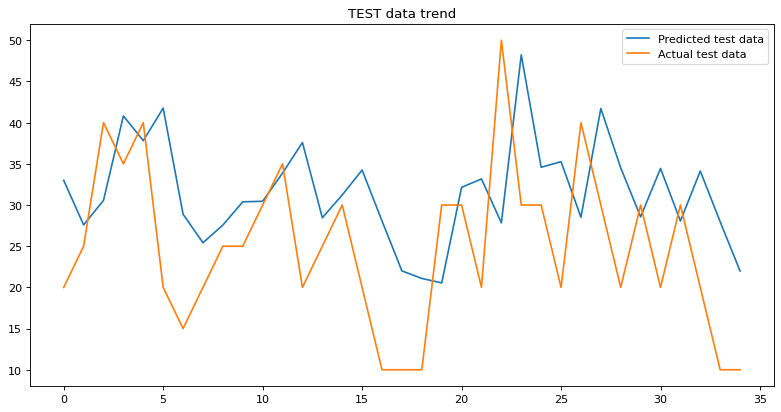

In [ ]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

predicted_test_inv = scaler.inverse_transform(predicted_test)
actual_test_inv = scaler.inverse_transform(actual_test)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
plt.title("TEST data trend")
plt.show()

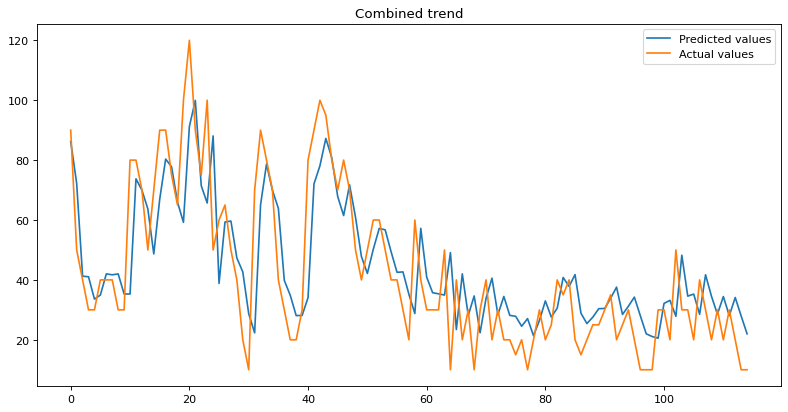

In [ ]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)
actual_combined_inv = scaler.inverse_transform(actual_combined)
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
plt.title("Combined trend")
plt.show()

### Calculating the R2 score

In [ ]:
from sklearn.metrics import r2_score

# Train, test, combined
print(round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

0.567 ,  -0.519 ,  0.611


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [ ]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print(round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


17.609 ,  11.784 ,  16.062


### Analysis
**1. Sequence size of 3, train size of 0.7**
1. Lag is still present, but reduced.
2. Trend in test data is being followed to some degree. (gets better with more neurons).
3. Values in the test data are higher than the mean.
4. r2 score: 0.586 ,  -0.661 ,  0.627
5. RMSE: 17.751 ,  12.199 ,  16.246

**2. Sequence size of 15, train size of 0.7**  
1. Training data: The lag has decreased by a huge degree. But the predicted values sometimes underpredict the change.
2. Test data: The trend is not being followed, values are close to the mean.
3. r2 score: 0.744 ,  -0.089 ,  0.763
4. RMSE: 13.921 ,  10.015 ,  12.857

**3. Sequence size of 5, train size of 0.7**  
1. Train data: lag is present, but the trend is being followed consistently.
2. Test data: The best trend was shown by this configuration. But The lag is consistent and the values are slightly higher than actual.
3. r2 score: 0.567 ,  -0.519 ,  0.611
4. RMSE: 17.609 ,  11.784 ,  16.062

**4. Sequence size of 7, train size of 0.7**  
1. Train data: The trend has gotten worse, with lag being consistently present.
2. Test data: The trend has gottne worse, lag values are very high. The only good point is that the values are closer to the mean (with a faint laggy trend).
3. r2 score: 0.633 ,  -0.336 ,  0.661
4. RMSE: 16.226 ,  11.168 ,  14.886


## c) 2 LSTM layers, 32 neurons each

In [ ]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 5, 32)             4352      
                                                                 
 lstm_43 (LSTM)              (None, 32)                8320      
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 4s 367ms/step - loss: 0.9493 - val_loss: 0.5148
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.9256 - val_loss: 0.5001
Epoch 3/100
3/3 [==============================] - 0s 21ms/step - loss: 0.9065 - val_loss: 0.4789
Epoch 4/100
3/3 [==============================] - 0s 24ms/step - loss: 0.8890 - val_loss: 0.4565
Epoch 5/100
3/3 [==============================] - 0s 32ms/step - loss: 0.8724 - val_loss: 0.4343
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 0.8543 - val_loss: 0.4134
Epoch 7/100
3/3 [==============================] - 0s 22ms/step - loss: 0.8391 - val_loss: 0.3914
Epoch 8/100
3/3 [==============================] - 0s 30ms/step - loss: 0.8200 - val_loss: 0.3710
Epoch 9/100
3/3 [==============================] - 0s 29ms/step - loss: 0.7963 - val_loss: 0.3534
Epoch 10/100
3/3 [==============================] - 0s 24ms/step - loss: 0.7802 - val_loss: 0.3420
Epoch 11/100
3/3 [

### Plotting the loss

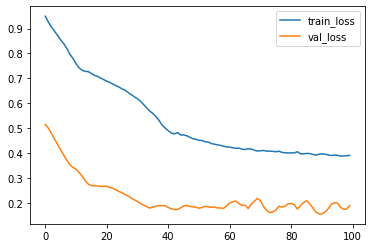

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 6ms/step


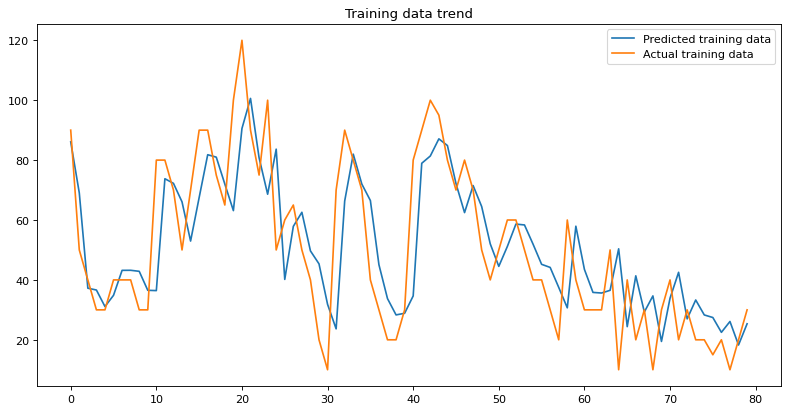

In [ ]:
# TRAINING DATA

# Making predctions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

predicted_train_inv = scaler.inverse_transform(predicted_train)
actual_train_inv = scaler.inverse_transform(actual_train)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
plt.title("Training data trend")
plt.show()

2/2 [==============================] - 0s 7ms/step


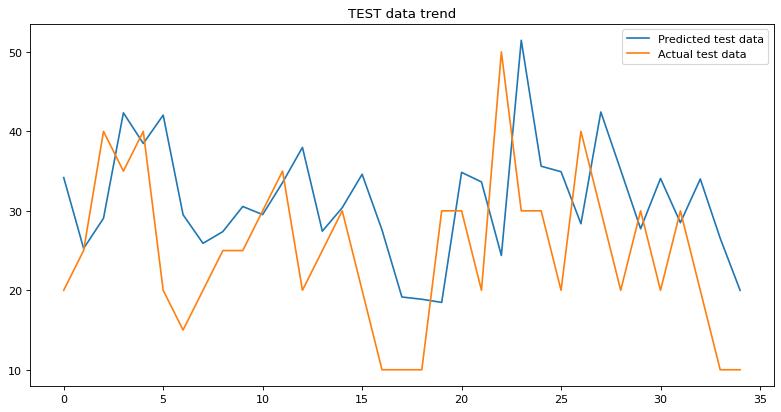

In [ ]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

predicted_test_inv = scaler.inverse_transform(predicted_test)
actual_test_inv = scaler.inverse_transform(actual_test)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
plt.title("TEST data trend")
plt.show()

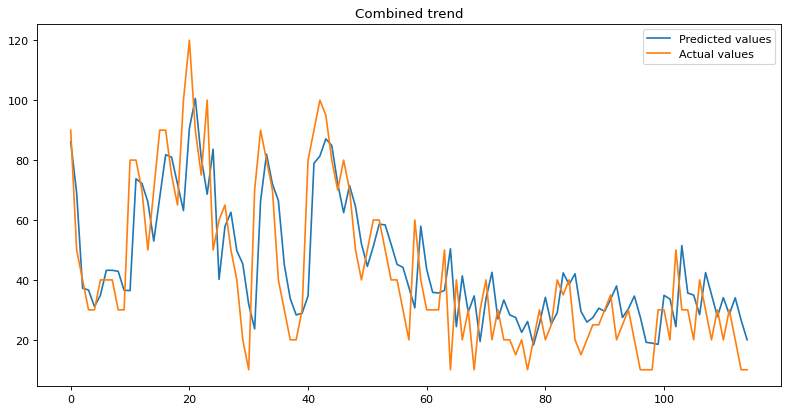

In [ ]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)
actual_combined_inv = scaler.inverse_transform(actual_combined)
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
plt.title("Combined trend")
plt.show()

### Calculating the R2 score

In [ ]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score:", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score: 0.58 ,  -0.615 ,  0.616


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [ ]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  17.353 ,  12.153 ,  15.951


### Analysis
**1. Sequence size of 3, train size of 0.7**
1. Train data: Lag is present, and the trend is being followed. But larger changes are not being captured completely.
2. Test data: The trend is being followed very nicely, but lag is present and values are slightly larger than expected
3. r2 score: 0.596 ,  -0.598 ,  0.637
4. RMSE: 17.531 ,  11.963 ,  16.025

**2. Sequence size of 5, train size of 0.7**  
1. Train data: Lag has reduced a bit, trend is being followed about 85% correctly.
2. Test data: Trend is followed to the best extent. Big lag is still present, values are above the mean.
3. r2 score: 0.58 ,  -0.615 ,  0.616
4. RMSE:  17.353 ,  12.153 ,  15.951


## d) 3 LSTM layers, 32 neurons each

In [ ]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 5, 32)             4352      
                                                                 
 lstm_54 (LSTM)              (None, 5, 32)             8320      
                                                                 
 lstm_55 (LSTM)              (None, 32)                8320      
                                                                 
 dense_53 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200)

Epoch 1/200
3/3 [==============================] - 7s 466ms/step - loss: 0.9561 - val_loss: 0.5762
Epoch 2/200
3/3 [==============================] - 0s 25ms/step - loss: 0.9448 - val_loss: 0.5793
Epoch 3/200
3/3 [==============================] - 0s 26ms/step - loss: 0.9336 - val_loss: 0.5767
Epoch 4/200
3/3 [==============================] - 0s 28ms/step - loss: 0.9236 - val_loss: 0.5713
Epoch 5/200
3/3 [==============================] - 0s 26ms/step - loss: 0.9133 - val_loss: 0.5668
Epoch 6/200
3/3 [==============================] - 0s 26ms/step - loss: 0.8994 - val_loss: 0.5620
Epoch 7/200
3/3 [==============================] - 0s 27ms/step - loss: 0.8862 - val_loss: 0.5557
Epoch 8/200
3/3 [==============================] - 0s 25ms/step - loss: 0.8700 - val_loss: 0.5478
Epoch 9/200
3/3 [==============================] - 0s 25ms/step - loss: 0.8474 - val_loss: 0.5415
Epoch 10/200
3/3 [==============================] - 0s 30ms/step - loss: 0.8343 - val_loss: 0.5386
Epoch 11/200
3/3 [

### Plotting the loss

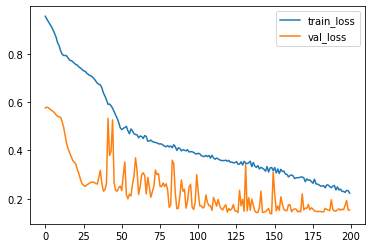

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 6ms/step


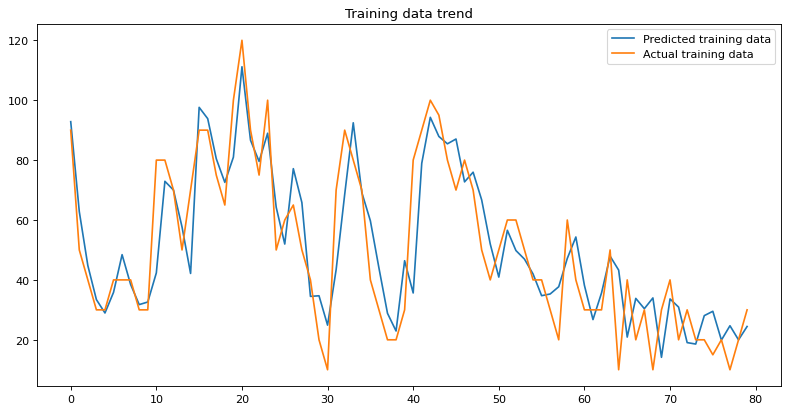

In [ ]:
# TRAINING DATA

# Making predctions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

predicted_train_inv = scaler.inverse_transform(predicted_train)
actual_train_inv = scaler.inverse_transform(actual_train)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
plt.title("Training data trend")
plt.show()

2/2 [==============================] - 0s 8ms/step


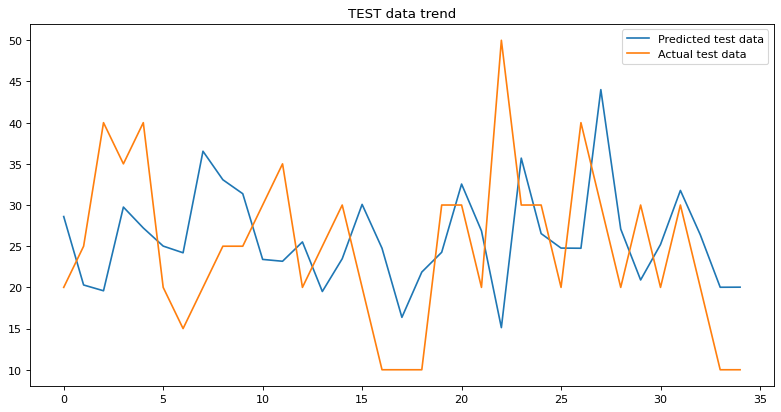

In [ ]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

predicted_test_inv = scaler.inverse_transform(predicted_test)
actual_test_inv = scaler.inverse_transform(actual_test)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
plt.title("TEST data trend")
plt.show()

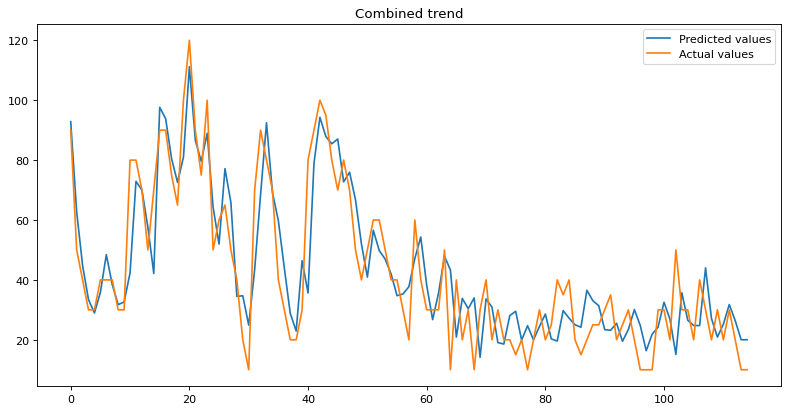

In [ ]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)
actual_combined_inv = scaler.inverse_transform(actual_combined)
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
plt.title("Combined trend")
plt.show()

### Calculating the R2 score

In [ ]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score:", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score: 0.754 ,  -0.307 ,  0.76


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [ ]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  13.288 ,  10.933 ,  12.618


### Analysis

**1. Sequence size of 5, train size of 0.7, 200 epochs**  
1. Train data: Lag has been reduced considerably, trend is being followed 90%.
2. Test data: Huge lag is present. Trend is being followed to some extent, but the values are mostly near the mean. 
This shows possible overfitting. (Smaller epochs showed worse performance, even on the training data)
3. r2 score: 0.754 ,  -0.307 ,  0.76
4. RMSE: 13.288 ,  10.933 ,  12.618
